### Configuração Inicial

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

# Carregar dados
users = pd.read_csv("./../data/users.csv")
movies = pd.read_csv("./../data/movies.csv")
interactions = pd.read_csv("./../data/interactions.csv")

### Pré-processamento dos Dados

#### a) Processar gêneros

In [50]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# Converter a coluna de gêneros preferidos de forma segura
def safe_convert_to_list(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except (ValueError, SyntaxError):
        return []

users["preferredGenres"] = users["preferredGenres"].apply(safe_convert_to_list)

# Processar gêneros dos filmes (tratando valores nulos e normalizando)
movies["genres"] = movies["genres"].apply(
    lambda x: [g.strip().title() for g in x.split(",")] if pd.notnull(x) else []
)

# Criar lista única de todos os gêneros
all_genres = set()

# Processar gêneros dos usuários
for genres in users["preferredGenres"]:
    all_genres.update([g.strip().title() for g in genres])

# Processar gêneros dos filmes
for genres in movies["genres"]:
    all_genres.update([g.strip().title() for g in genres])

all_genres = sorted(list(all_genres))

# Codificador multi-hot
mlb = MultiLabelBinarizer(classes=all_genres)
mlb.fit([all_genres])  # Forçar o mesmo conjunto de classes

# Aplicar codificação
users["preferredGenres_encoded"] = users["preferredGenres"].apply(
    lambda x: mlb.transform([x])[0].tolist()
)

movies["genre_encoded"] = movies["genres"].apply(
    lambda x: mlb.transform([x])[0].tolist()
)

/home/pedro/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Ficção científica'] will be ignored
  warnings.warn(
/home/pedro/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cinema TV', 'Ficção científica'] will be ignored
  warnings.warn(
/home/pedro/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Cinema TV'] will be ignored
  warnings.warn(


Salvar o MultiLabelBinarizer treinado

In [51]:
import joblib

joblib.dump(mlb, "./../saved_models/genres_label_binarizer.pkl")
print("MultiLabelBinarizer salvo com sucesso!")

MultiLabelBinarizer salvo com sucesso!


In [52]:
import pickle

with open("./../saved_models/genres_label_binarizer.pkl", "wb") as f:
    pickle.dump(mlb, f)
    print("MultiLabelBinarizer dos gêneros salvo com sucesso!")

MultiLabelBinarizer dos gêneros salvo com sucesso!


In [53]:
movies.head()

,movieId,title,genres,genre_encoded
0,c36b8c6f-addf-4c62-9109-5e6c47ca6935,Sonic the Hedgehog 3,"[Ação, Ficção Científica, Comédia, Família]","[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
1,d23f94f0-32cb-4925-acc5-6deeadd3721f,Kraven the Hunter,"[Ação, Ficção Científica, Aventura, Fantasia, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
2,b5313d17-29b6-4fb5-8164-ff79b5cf9627,Back in Action,"[Ação, Comédia]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ea105795-fc9c-4154-944b-d9402d2aeafb,Nosferatu,[Terror],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,140a1ecc-9afd-4264-abbc-0999bcee2804,Mufasa: The Lion King,"[Aventura, Família, Animação]","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [54]:
users.head()

,id,age,gender,preferredGenres,location,acceptsRecommendations,preferredGenres_encoded
0,8d410afe-bcac-412d-876a-164e8e3ee647,18,M,"[Thriller, História, Faroeste]",Porto Alegre,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
1,41690a70-94f8-4c9f-bd2a-0bcda8e4ba86,37,M,"[Ficção científica, Ação, Fantasia]",Belo Horizonte,False,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,6ef516b8-c939-4073-a5c3-90e2d1e934d0,48,F,"[Fantasia, Guerra, Família]",Recife,True,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, ..."
3,ce1a6638-dcc4-4403-808b-9e5036a17081,46,F,"[Fantasia, Comédia, Aventura]",Curitiba,True,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,123b60a3-8faa-44c4-9f36-9393acdb7c1d,39,M,"[Ficção científica, Guerra, Thriller]",Fortaleza,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [55]:
interactions.head()

,userId,movieId,totalInteractions,totalWatchTime
0,918387f9-3d8d-48d1-b294-fc85f6b8dd44,59b24782-d99d-44bd-88fa-f8d7138e8b8c,2,117
1,b481fc5e-9fe5-434a-ae84-b6ddab2858a5,0a2e21da-fe10-4c0b-a2a0-c0dd1d41ea28,3,181
2,64683b69-20b3-4709-a97b-229f710b8e7d,d7809fcd-e8a1-46a7-a45c-8783eaa4c8ed,1,30
3,2b4494b8-107d-4887-9728-9fd7f47a0260,ebfb9880-2fcb-40ec-a1f8-c9d681788d81,3,166
4,68eca4b3-752f-4d3f-b7c8-b74ed51dbf8a,ea2d76f7-a1ce-4407-a66b-6164b09b9bfd,1,231


#### Codificar IDs

In [56]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Codificar user_id e movie_id
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

users["user_id_encoded"] = user_encoder.fit_transform(users["id"])
movies["movie_id_encoded"] = movie_encoder.fit_transform(movies["movieId"])
interactions["user_id_encoded"] = user_encoder.transform(interactions["userId"])
interactions["movie_id_encoded"] = movie_encoder.transform(interactions["movieId"])

In [57]:
# Salvar o encoder do usuário

with open("./../saved_models/user_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

In [58]:
# Salvar o encoder do filme

with open("./../saved_models/movie_encoder.pkl", "wb") as f:
    pickle.dump(movie_encoder, f)

#### Normalizar features numéricas

In [59]:
scaler = MinMaxScaler()
users["age_normalized"] = scaler.fit_transform(users[["age"]])

In [60]:
# Salvar o scaler da idade do usuário

with open("./../saved_models/users_age_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [65]:
from sklearn.preprocessing import OneHotEncoder

gender_encoder = OneHotEncoder(sparse_output=False)

gender_encoded = gender_encoder.fit_transform(users[["gender"]])
gender_encoded = users["gender"]
gender_encoded_columns = [f'gender_{category}' for category in gender_encoder.categories_[0]]
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_encoded_columns, index=users.index)

# Concatenar as colunas codificadas ao DataFrame 'users'
users = pd.concat([users, gender_encoded_df], axis=1)

In [66]:
# Salvar o scaler do gênero do usuário

with open("./../saved_models/gender_encoder.pkl", "wb") as f:
    pickle.dump(gender_encoder, f)

### Preparar o Dataset Final

In [67]:
# Merge de dados
merged_data = interactions.merge(
    users[["user_id_encoded", "age_normalized", "gender", "preferredGenres_encoded"] + gender_encoded_columns],
    on="user_id_encoded"
).merge(
    movies[["movie_id_encoded", "genre_encoded"]],
    on="movie_id_encoded"
)

# Converter arrays para numpy
merged_data["preferredGenres_encoded"] = merged_data["preferredGenres_encoded"].apply(
    lambda x: np.array(x, dtype=np.float32)
)
merged_data["genre_encoded"] = merged_data["genre_encoded"].apply(
    lambda x: np.array(x, dtype=np.float32)
)

# Criar target (normalização do tempo assistido)
merged_data["target"] = merged_data["totalWatchTime"] / merged_data["totalWatchTime"].max()

In [78]:
# Corrigir para usar as colunas corretas:
merged_data["user_features"] = merged_data["preferredGenres_encoded"]
merged_data["movie_features"] = merged_data["genre_encoded"]

In [79]:
merged_data["user_features"] = merged_data.apply(
    lambda row: np.concatenate(
        [row["preferredGenres_encoded"], np.array([row["age_normalized"]])] + [row[col] for col in gender_encoded_columns]
    ),
    axis=1
)

### Construção do Modelo

In [80]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

#-----------------------------------------------------------
# Camadas de Input (APENAS features, sem IDs)
#-----------------------------------------------------------
user_features_input = Input(shape=(20,), name="user_features")  # 20 features do usuário (age + 19 gêneros de filmes preferidos)
movie_features_input = Input(shape=(19,), name="movie_features")  # 19 features do filme (gêneros)

#-----------------------------------------------------------
# Concatenar as Features
#-----------------------------------------------------------
combined = Concatenate()([
    user_features_input,
    movie_features_input
])  # Shape resultante: (None, 39)

#-----------------------------------------------------------
# Camadas Densas
#-----------------------------------------------------------
x = Dense(128, activation="relu")(combined)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)  # Saída entre 0 e 1

#-----------------------------------------------------------
# Modelo Final (APENAS 2 inputs)
#-----------------------------------------------------------
model = Model(
    inputs=[user_features_input, movie_features_input],  # Sem user_id/movie_id
    outputs=output
)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [75]:
merged_data["user_features"].values

array([array([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
              0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan],
             dtype=object)                                                    ,
       array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,
              0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4761904761904761, nan, nan, nan,
              nan], dtype=object)                                             ,
       array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
              0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7380952380952379, nan, nan, nan,
              nan], dtype=object)                                             ,
       array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
              1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3095238095238095, nan, nan, nan,
              nan], dtype=object)                                             ,
       array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0

In [87]:
y_train

array([0.64666665, 0.595     , 0.755     , 0.37666667, 0.11      ,
       0.915     , 0.745     , 0.42166665, 0.46333334, 0.24666667,
       0.13      , 0.16166666, 0.47833332, 0.26666668, 0.35      ,
       0.59      , 0.41666666, 0.32166666, 0.375     , 0.5466667 ,
       0.085     , 0.38166666, 0.32333332, 0.47333333, 0.6566667 ,
       0.69666666, 0.275     , 0.885     , 0.945     , 0.44833332,
       0.94      , 0.12      , 0.61333334, 0.5783333 , 0.72833335,
       0.645     , 0.9       , 0.22166666, 0.28166667, 0.21      ,
       0.6483333 , 0.7316667 , 0.18      , 0.375     , 0.85      ,
       0.14833333, 0.365     , 0.75166667, 0.5       , 0.43333334,
       0.7683333 , 0.275     , 0.725     , 0.07166667, 0.27833334,
       0.295     , 0.27666667, 0.93833333, 0.15833333, 0.885     ,
       0.955     , 0.255     , 0.355     , 0.405     , 0.10333333,
       0.54      , 0.6116667 , 0.07833333, 0.15333334, 0.5283333 ,
       0.34833333, 0.8833333 , 0.83      , 0.16333333, 0.135  

### Treinamento

In [86]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Criar X como dicionário de arrays 2D
X = {
    "user_features": np.vstack(merged_data["user_features"].values),
    "movie_features": np.vstack(merged_data["movie_features"].values)
}

y = merged_data["target"].values
y = y.astype(np.float32)  # Fix: remove the parentheses

# 2. Verificar dimensões
print("Dimensões de X:")
print("user_features:", X["user_features"].shape)
print("movie_features:", X["movie_features"].shape)
print("y:", y.shape)

# 3. Divisão treino-teste
indices = np.arange(len(y))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

X_train = {
    "user_features": X["user_features"][train_indices, :],
    "movie_features": X["movie_features"][train_indices, :]
}

X_test = {
    "user_features": X["user_features"][test_indices, :],
    "movie_features": X["movie_features"][test_indices, :]
}

y_train = y[train_indices]
y_test = y[test_indices]

# 4. Treinar o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    shuffle=True
)

Dimensões de X:
user_features: (500, 24)
movie_features: (500, 19)
y: (500,)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

### Previsões

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0892 - mae: 0.2551 
Test Loss: 0.0980
Test MAE: 0.2698


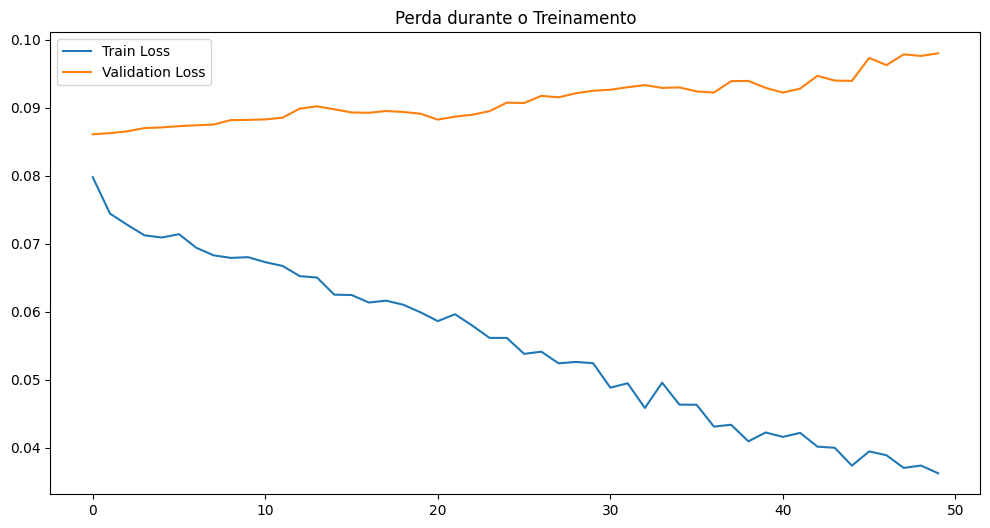

In [ ]:
import matplotlib.pyplot as plt

# Avaliar no conjunto de teste
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# Plotar histórico de treinamento
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Perda durante o Treinamento")
plt.show()

In [ ]:
# Salvar o modelo de aprendizagem de máquina

with open("./../saved_models/user_recommendation_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
import joblib

joblib.dump(model, "user_recommendation_model.pkl")
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


#### Carregar os modelos salvos

In [ ]:
# Carregar o modelo de aprendizagem de máquina

import pickle

with open("./../saved_models/user_recommendation_model.pkl", "rb")as file:
    modelo_salvo = pickle.load(file)

In [ ]:
# Carregar o label binarizer dos gêneros

with open("./../saved_models/genres_label_binarizer.pkl", "rb")as file:
    genres_label_binarizer = pickle.load(file)

In [ ]:
# Carregar o scaler das idades dos usuários

with open("./../saved_models/users_age_scaler.pkl", "rb")as file:
    users_age_scaler = pickle.load(file)

In [ ]:
# Exemplo: prever para um usuário e filme específico
# Supondo que você tenha acesso aos dados originais (users.csv e movies.csv)

# Dados de exemplo
user_id = "6ef516b8-c939-4073-a5c3-90e2d1e934d0"
movie_id = "09352cf7-d77b-47af-b09a-25319d9706b1"

user_data = users[users["id"] == user_id].iloc[0]

# 2. Processar features do usuário
# Converter gêneros para lista e aplicar title case
user_genres = [g.strip().title() for g in user_data["preferredGenres"]]
user_age = user_data["age"]

# Codificar gêneros do usuário (usar o mesmo encoder do treino)
user_genres_encoded = genres_label_binarizer.transform([user_genres])[0]

# Normalizar idade (usar o mesmo scaler do treino)
user_age_normalized = users_age_scaler.transform([[user_age]])[0][0]

# Combinar features (gêneros + idade)
user_features = np.concatenate([user_genres_encoded, [user_age_normalized]])

# 3. Buscar dados do filme
movie_data = movies[movies["movieId"] == movie_id].iloc[0]

# 4. Processar features do filme
# Acessar a lista de gêneros já pré-processada
movie_genres = movie_data["genres"]

# Garantir formatação consistente (strip e title case)
movie_genres = [g.strip().title() for g in movie_genres]

# Codificar usando o MultiLabelBinarizer
movie_features = genres_label_binarizer.transform([movie_genres])[0]

# 5. Criar input para o modelo
input_data = {
    "user_features": np.array([user_features], dtype=np.float32),  # (1, 20)
    "movie_features": np.array([movie_features], dtype=np.float32)  # (1, 19)
}

# 6. Fazer previsão
prediction = modelo_salvo.predict(input_data)[0][0]

print(f"Probabilidade de interesse do usuário {user_id} no filme {movie_data['title']}: {prediction:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Probabilidade de interesse do usuário 6ef516b8-c939-4073-a5c3-90e2d1e934d0 no filme The Chronicles of Narnia: The Lion, the Witch and the Wardrobe: 54.15%


/home/pedro/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np

# Dados do usuário específico
user_id = "6ef516b8-c939-4073-a5c3-90e2d1e934d0"
user_data = users[users["id"] == user_id].iloc[0]

# Processar features do usuário (uma única vez)
user_genres = [g.strip().title() for g in user_data["preferredGenres"]]
user_age = user_data["age"]
user_genres_encoded = genres_label_binarizer.transform([user_genres])[0]
user_age_normalized = users_age_scaler.transform([[user_age]])[0][0]
user_features = np.concatenate([user_genres_encoded, [user_age_normalized]])

# Lista para armazenar resultados
predictions = []

# Iterar sobre todos os filmes
for _, movie in movies.iterrows():
    # Processar features do filme
    movie_genres = [g.strip().title() for g in movie["genres"]]
    movie_features = genres_label_binarizer.transform([movie_genres])[0]
    
    # Criar input
    input_data = {
        "user_features": np.array([user_features], dtype=np.float32),
        "movie_features": np.array([movie_features], dtype=np.float32)
    }
    
    # Previsão
    score = model.predict(input_data)[0][0]
    predictions.append((movie["movieId"], movie["title"], score))

# Converter para DataFrame e ordenar
df_predictions = pd.DataFrame(predictions, columns=["movieId", "title", "score"])
df_predictions = df_predictions.sort_values(by="score", ascending=False).reset_index(drop=True)

# Mostrar top 10
print(f"Top 10 recomendações para o usuário {user_id}:\n")
print(df_predictions.head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/home/pedro/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [ ]:
input = {
    "user_id": "8b798371-6996-4889-8289-a43d427f0b30",
    "movie_id": "4cf4a317-0bad-427e-8ccc-906fd6118839",
    "age": 25,
    "gender": "Male",
    "preferredGenres": ["Crime", "Ação"],
    "totalInteractions": 15,
    "totalWatchTime": 2540,
    "movieGenres": ["Comédia"]
}

input.pop("user_id")
input.pop("movie_id")
input["age"] = users_age_scaler.transform(input["age"])

prediction = model.predict(input)

print(f"Probabilidade de interesse: {prediction[0][0]:.2%}")

ValueError: Unrecognized data type: x={'user_id': '8b798371-6996-4889-8289-a43d427f0b30', 'movie_id': '4cf4a317-0bad-427e-8ccc-906fd6118839', 'age': 25, 'gender': 'Male', 'preferredGenres': ['Crime', 'Ação'], 'totalInteractions': 15, 'totalWatchTime': 2540, 'movieGenres': ['Comédia']} (of type <class 'dict'>)

Modelo salvo com sucesso!


In [ ]:
# Carregar o scaler salvo durante o treinamento
scaler = joblib.load("model/scaler.pkl")
age_normalized = scaler.transform([[data.age]])[0][0]  # Normalizar a idade

{'user_id': array([44, 82, 70, 33, 72, 98, 18,  3, 19, 99, 34,  4, 84, 64, 53, 46, 46,
        26, 14, 77, 44, 54, 46, 79, 73, 12, 35, 32, 78, 94, 20,  1, 69, 89,
        64, 49, 39, 90, 98, 12, 29, 42, 30, 10, 28, 65, 79, 78, 56, 74,  0,
        15, 41, 14, 32, 36, 68,  2, 35, 72, 48, 62, 17, 19, 88, 65, 99, 81,
        56, 11, 36,  0, 45, 80, 94, 68, 15,  4, 53, 65, 23,  7, 93, 33, 71,
        19, 56, 27, 88, 70, 41, 90, 74, 71, 77, 40, 87, 61, 12, 60,  3, 85,
        52, 41, 59, 63, 30, 48, 39,  9, 24, 27, 37, 36, 46, 10, 47,  7, 92,
        47, 30, 32, 20,  4, 69, 66, 84, 17, 73, 61, 94, 29,  5, 91, 62, 11,
        62, 70, 37, 95, 78, 49, 23, 74, 99,  9, 99, 28, 57, 93, 63, 67, 20,
         9, 17, 17,  5, 22, 86, 52, 84, 64,  0, 11, 68, 58, 67, 75, 43, 18,
        17, 76, 84, 36, 81, 75, 62, 98, 78, 22, 43,  8, 31, 33, 12, 64, 38,
        98, 86,  2, 68, 94, 56,  9, 85, 10, 78, 19, 62, 71, 51, 97, 42, 46,
         5, 79, 36, 20, 70, 26, 75,  2, 96, 14, 26, 45, 34, 22, 60,  0, 65,
 